In [2]:
from yahoo_fin import stock_info as si
import pandas as pd
import numpy as np
from typing import List
import yfinance as yf
import re
from io import BytesIO, StringIO
import boto3
import psycopg2

In [24]:
conn_string = "dbname='dev' "
conn_string += "port='5439' "
conn_string += "user='xx' "
conn_string += "password='xx' "
conn_string += "host='xx'"  


#connect to Redshift
con = psycopg2.connect(conn_string)

sql = ("""SELECT spot_prices.symbol, spot_prices.year,spot_prices.month, spot_prices.day,
spot_prices.closing_price, spot_prices.volume, spot_prices.quarter,
m3_money_supply.value as money_supply, m3_money_supply.country as central_bank,
tickers.indices, 
spot_prices.closing_price/fund.netinc*fund.shareswa as pe_ratio
from spot_prices
inner join m3_money_supply 
on  m3_money_supply.quarter = spot_prices.quarter
AND  m3_money_supply.year = spot_prices.year
inner join (SELECT * from fundamentals
WHERE dimension = 'ARY'
AND netinc > 0.0) as fund
on  fund.year = spot_prices.year
AND  fund.ticker = spot_prices.symbol
inner join tickers 
on tickers.symbol = spot_prices.symbol;
""")

cur = con.cursor()
cur.execute(sql)
rows = cur.fetchall()
con.close() 

In [41]:
cols = [
    "symbol",
    "year",
    "month",
    "day",
    "closing_price",
    "valume",
    "quarter",
    "money_supply",
    "central_bank",
    "indices",
    "pe_ratio"
]
df = pd.DataFrame(rows, columns = cols )

In [42]:
df.head(10)

,symbol,year,month,day,closing_price,valume,quarter,money_supply,central_bank,indices,pe_ratio
0,ABC,1999,11,3,3.281250,4517600.0,Q4,38.30906,United States,S&P 500,9.862912
1,ABC,1999,11,3,3.281250,4517600.0,Q4,43.50537,Euro area (19 countries),S&P 500,9.862912
2,AIG,1999,11,3,1354.166626,179205.0,Q4,38.30906,United States,"S&P 100,S&P 500",31.101631
3,AIG,1999,11,3,1354.166626,179205.0,Q4,43.50537,Euro area (19 countries),"S&P 100,S&P 500",31.101631
4,ARE,1999,11,3,30.375000,24000.0,Q4,38.30906,United States,S&P 500,18.630000
5,ARE,1999,11,3,30.375000,24000.0,Q4,43.50537,Euro area (19 countries),S&P 500,18.630000
6,BBWI,1999,10,21,16.875505,1126907.0,Q4,38.30906,United States,S&P 500,3.749830
7,BBWI,1999,10,21,16.875505,1126907.0,Q4,43.50537,Euro area (19 countries),S&P 500,3.749830
8,BIO,1999,12,20,11.937500,8200.0,Q4,38.30906,United States,S&P 500,24.667371
9,BIO,1999,12,20,11.937500,8200.0,Q4,43.50537,Euro area (19 countries),S&P 500,24.667371


In [43]:
df_SP500_FED = df[df["central_bank"] == "United States"] 
df_SP500_FED = df_SP500_FED[df_SP500_FED["indices"].str.contains("S&P 500")] 

results = []
for year in df_SP500_FED["year"].unique():
    df_tmp = df_SP500_FED[df_SP500_FED["year"] == year]
    results.append(
    dict(
        year = year,
        avg_pre_ratio = np.mean(df_tmp["pe_ratio"].values),
        money_supply = np.mean(df_tmp["money_supply"].values)
    ))
    
df_sp500 = pd.DataFrame(results)

In [44]:
df_NASDAQ_FED = df[df["central_bank"] == "United States"] 
df_NASDAQ_FED = df_NASDAQ_FED[df_NASDAQ_FED["indices"].str.contains("NASDAQ 100")] 

results = []
for year in df_NASDAQ_FED["year"].unique():
    df_tmp = df_NASDAQ_FED[df_NASDAQ_FED["year"] == year]
    results.append(
    dict(
        year = year,
        avg_pre_ratio = np.mean(df_tmp["pe_ratio"].values),
        money_supply = np.mean(df_tmp["money_supply"].values)
    ))
    
df_nasdaq = pd.DataFrame(results)

## Average pe ratio over time

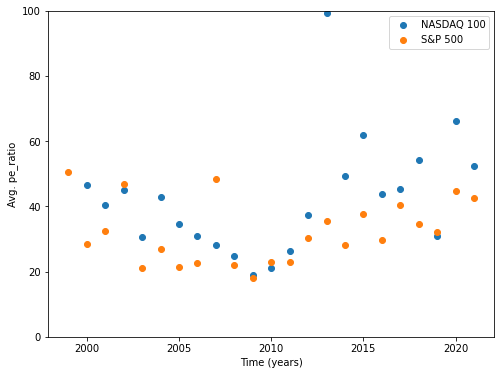

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,6))
plt.scatter(df_nasdaq["year"],df_nasdaq["avg_pre_ratio"], label = "NASDAQ 100")
plt.scatter(df_sp500["year"],df_sp500["avg_pre_ratio"], label = "S&P 500")
plt.ylabel("Avg. pe_ratio")
plt.xlabel("Time (years)")
plt.ylim((0,100))
plt.legend()

## Average pe ratio vs money supply

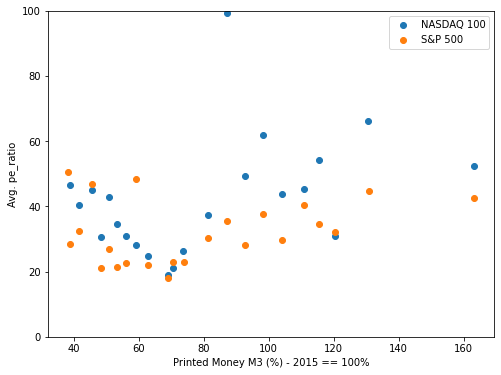

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,6))
plt.scatter(df_nasdaq["money_supply"],df_nasdaq["avg_pre_ratio"], label = "NASDAQ 100")
plt.scatter(df_sp500["money_supply"],df_sp500["avg_pre_ratio"], label = "S&P 500")
plt.ylabel("Avg. pe_ratio")
plt.xlabel("Printed Money M3 (%) - 2015 == 100%")
plt.ylim((0,100))
plt.legend()

## Average pe ratio vs money supply without 2008 crash

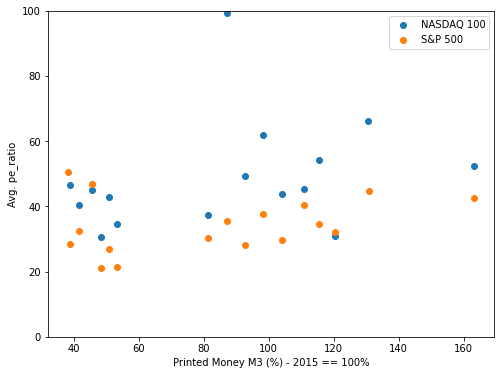

In [84]:
import matplotlib.pyplot as plt

df_nasdaq_v2 = df_nasdaq[df_nasdaq["year"].isin([2006, 2007,2008,2009,2010,2011]) == False]

df_sp500_v2 = df_sp500[df_sp500["year"].isin([2006, 2007,2008,2009,2010,2011]) == False]

plt.figure(figsize = (8,6))
plt.scatter(df_nasdaq_v2["money_supply"],df_nasdaq_v2["avg_pre_ratio"], label = "NASDAQ 100")
plt.scatter(df_sp500_v2["money_supply"],df_sp500_v2["avg_pre_ratio"], label = "S&P 500")
plt.ylabel("Avg. pe_ratio")
plt.xlabel("Printed Money M3 (%) - 2015 == 100%")
plt.ylim((0,100))
plt.legend()

In [74]:
np.corrcoef(df_nasdaq_v2["money_supply"].values,df_nasdaq_v2["avg_pre_ratio"])

array([[ 1.        , -0.15033428],
       [-0.15033428,  1.        ]])

In [75]:
np.corrcoef(df_sp500_v2["money_supply"].values,df_sp500_v2["avg_pre_ratio"])

array([[1.        , 0.26499834],
       [0.26499834, 1.        ]])

## S&P 500 Index value vs. money supply

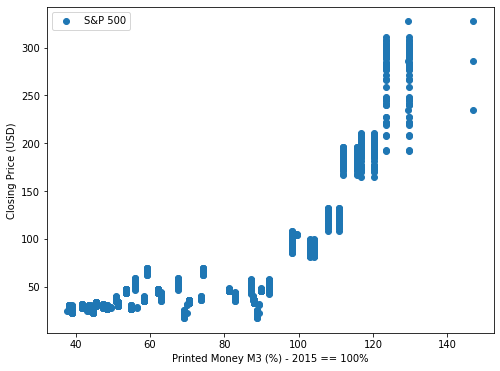

In [83]:
import matplotlib.pyplot as plt

df_SP500_index = df[df["symbol"].str.contains("SPGI")]

plt.figure(figsize = (8,6))
plt.scatter(df_SP500_index["money_supply"],df_SP500_index["closing_price"], label = "S&P 500")
plt.ylabel("Closing Price (USD)")
plt.xlabel("Printed Money M3 (%) - 2015 == 100%")
plt.legend()

In [80]:
np.corrcoef(df_SP500_index["money_supply"].values,df_SP500_index["closing_price"])

array([[1.        , 0.80549718],
       [0.80549718, 1.        ]])